### Задание 1. A/B–тестирование
##### 1.1 Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


##### 1.2 Входные данные  
В качестве входных данных Вы имеете 4 csv-файла:  
groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)   
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.   

##### 1.3 Вопросы  
Предлагаем Вам ответить на следующие вопросы:  
На какие метрики Вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.  

##### 1.4 Требования к ответу  
При выполнении тестового задания необходимо использовать язык программирования Python.   
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.   
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.  

In [1]:
#Импорт модулей
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.figure(figsize=(20,20))

In [2]:
#загружаем данные. в следующей строке можно задать переменную пути и добавить ее при чтении файлов
#path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zorenko-20/Final_project/Variant_2/'
groups = pd.read_csv("Проект_2_groups.csv", sep=';')
group_add = pd.read_csv("Проект_2_group_add.csv")
active_studs = pd.read_csv("Проект_2_active_studs.csv")
checks = pd.read_csv("Проект_2_checks.csv", sep=';')

In [3]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [5]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [6]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


осмотрим фреймы:

In [7]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
#не замечаем аномалий в типах и наполнении данных. Объеденим данные по чеками и активными во время теста пользователями.
active_checks = active_studs.merge(checks, how='inner', on='student_id')
active_checks.shape

(392, 2)

#### Замечаем, что кол-ов записей стало меньше, чем было в таблице с чеками. Возможно чеки содержат заказы, которые были например до начала эксперимента, но оплата пришла уже позже, во время эксперимента, или в таблицу попали чеки пользователей, которые не попали ни в группу А ни в группу В. Или присутствует ошибка в данных. Такие чеки в будущих джойнах исключим.

In [16]:
#добавим данные с пользователями из дополнительного файла к основному:
groups_full = pd.concat([groups, group_add], ignore_index=True)
groups_full.shape #Видим корректное объединение фреймов. Кол-во записей равно сумарному по обоим фреймам.


(74576, 2)

In [17]:
#собираем полный дата фрейм, добавляя к группам активных пользователей по условнию inner, затем добавляем чеки, сохраняя остальные данные, удаляем дублирующую колонку, заменим отсутствующие данные на нули:
groups_full_active = groups_full.merge(active_studs, how='inner', left_on='id', right_on='student_id')
df = groups_full_active.merge(checks, how='left', on='student_id')
df = df.drop(columns='id')
df = df.fillna(0)
df.head()

,grp,student_id,rev
0,A,1627,990.0
1,B,2085,0.0
2,B,2215,0.0
3,A,3391,0.0
4,B,3401,0.0


#### Теперь мы имеем полный датафрейм для анализа метрик и проведения A/B тестов.

In [18]:
#На основе представленных данных можно рассчитать несколько метрик:
#Revenue (доход по группам)
#Средний чек
#ARPU (средний доход с пользователя)
#ARPPU (средний доход с платящего пользователя)
#CR (конверсия в покупку)

In [19]:
#Revenue (доход по группам)
df.groupby('grp', as_index=False) \
            .agg({'rev': 'sum'}).round(2) \
            .rename(columns={'rev': 'revenue'})

,grp,revenue
0,A,72820.0
1,B,394974.0


In [20]:
#средний чек:
df.groupby('grp', as_index=False) \
            .agg({'rev': 'mean'}).round(2) \
            .rename(columns={'rev': 'revenue'})

,grp,revenue
0,A,47.35
1,B,58.06


In [21]:
#ARPU (средний доход с пользователя):
df.groupby('grp', as_index=False) \
            .agg({'rev': 'sum'}).round(2).rev \
                / \
df.groupby('grp', as_index=False) \
            .agg({'student_id': 'count'}).student_id

0    47.347204
1    58.058798
dtype: float64

In [22]:
#замечаем что срдений чек и ARPU равны, соответственно у кажого пользователя было по 1 покупке

In [23]:
#ARPPU (средний доход с платящего пользователя):
df.query('rev > 0').groupby('grp', as_index=False) \
            .agg({'rev': 'sum'}).round(2).rev \
            / \
df.query('rev > 0').groupby('grp', as_index=False) \
            .agg({'student_id': 'count'}).student_id

0     933.589744
1    1257.878981
dtype: float64

In [24]:
#CR (конверсия в покупку):
df['conv'] = df.rev > 0
df.groupby('grp').conv.mean().mul(100).round(2)

grp
A    5.07
B    4.62
Name: conv, dtype: float64

In [25]:
#средний чек вырос, проверим, значимое ли это отличие. Для начала проверим распределение на нормальность:
ss.shapiro(df.query('grp == "A"').rev)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

In [26]:
ss.shapiro(df.query('grp == "B"').rev)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

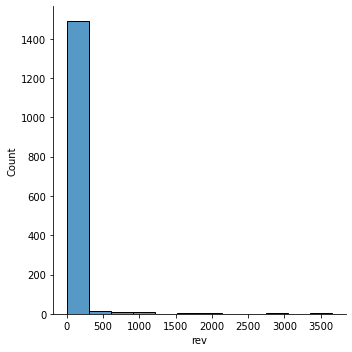

In [27]:
#Видим, что распределения не нормальные. Посмотрим на них визуально:
sns.displot(df.query('grp == "A"').rev, kde = False)

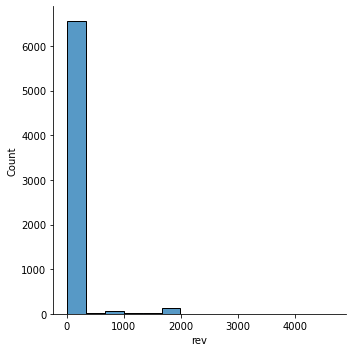

In [28]:
sns.displot(df.query('grp == "B"').rev, kde = False)

In [29]:
#Много нулевых значений чеков. Привести распределения к нормальным из-за нулевых хзначений через логарифмирование мы не можем. Следовательно лучше провести тест Манна-Уитни.
ss.mannwhitneyu(df.query('grp == "A"').rev, df.query('grp == "B"').rev)

MannwhitneyuResult(statistic=5252113.0, pvalue=0.5099747992861601)

#### Значимых различий в тесте мы не наблюдаем, но в группах очень много нулевых значений, как мы помним кол-во активных пользователей 8341, а чеков (после потери части их) всего 392, т.е. покупок было менее 5%.  Следовательно лучше сравнивать средний чек именно среди покупок, т.к. будут более заметны различия, при этом проверить изменение конверсии. Оставим только покупки, приведем распределение к нормальному через логарифмирование:

In [30]:
#проверяем что в группе B средний чек выше
df.query('grp == "B" and rev > 0').rev.mean() - df.query('grp == "A" and rev > 0').rev.mean()

324.2892484484729

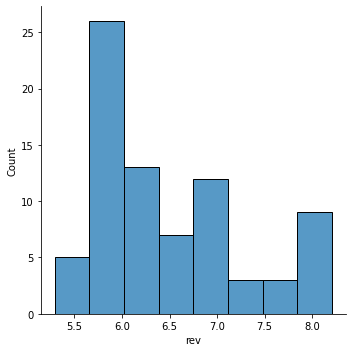

In [31]:
sns.displot(np.log(df.query('grp == "A" and rev > 0').rev), kde = False)

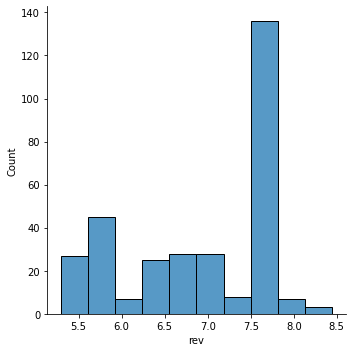

In [32]:
sns.displot(np.log(df.query('grp == "B" and rev > 0').rev), kde = False)

Text(0, 0.5, 'распределение чеков')

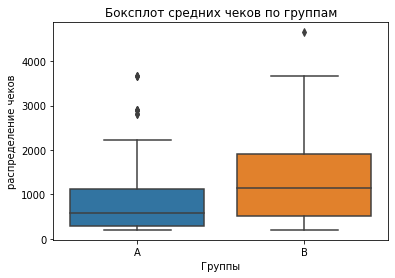

In [33]:
sns.boxplot(data=df.query('rev > 0'), x='grp', y='rev')
plt.title('Боксплот средних чеков по группам')
plt.xlabel('Группы')
plt.ylabel('распределение чеков')  

In [34]:
#проверяем распределение на нормальность дои после логарифмирования:
ss.shapiro(np.log(df.query('grp == "A" and rev > 0').rev))

ShapiroResult(statistic=0.9057686924934387, pvalue=2.680935176613275e-05)

In [35]:
ss.shapiro(df.query('grp == "A" and rev > 0').rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [36]:
ss.shapiro(np.log(df.query('grp == "B" and rev > 0').rev))

ShapiroResult(statistic=0.8419413566589355, pvalue=2.9242029102554055e-17)

In [37]:
ss.shapiro(df.query('grp == "B" and rev > 0').rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [38]:
#для проведения Т-теста нормальность групп желаемое, но не обязательное условие.
#у A группы нормальность больше при логарифмировании, у B - почти равны. Проводим Т-тест с логарифмированием:
ss.ttest_ind(np.log(df.query('grp == "A" and rev > 0').rev), np.log(df.query('grp == "B" and rev > 0').rev))

Ttest_indResult(statistic=-3.703936180867154, pvalue=0.00024290878418771448)

In [39]:
#проверим на всякий случай тест Манном-Уитни без логарифмирования, т.к. он не нужен, для такого не параметрического теста:
ss.mannwhitneyu(df.query('grp == "A" and rev > 0').rev, df.query('grp == "B" and rev > 0').rev)
#так же видим значимые значения

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

#### Получили статистически значимое отличие в обоих вариантах!

In [40]:
#вернемся к конферсии по группам:
df['conv'] = df.rev > 0
df.groupby('grp').conv.mean().mul(100).round(2)

grp
A    5.07
B    4.62
Name: conv, dtype: float64

In [41]:
#проверим значимость различий конверсии через хи-квадрат:
stat, p, dot, expected = ss.chi2_contingency(df.groupby('grp').agg({'conv': 'sum', 'student_id': 'count'}))
p

0.5089998823014525

### Мы провели A/B тест, который показал нам значимые различия в метрике ARPPU в большую сторону в группе B, при сохранении конверсии. Следовательно можно считать, что эксперимент удачный и можно распростронять новую механику на всех пользователей.

### Задание 2. SQL
##### 2.1 Очень усердные ученики.

##### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

##### 2.1.2 Задача

Дана таблица peas.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [42]:
#воспользуемся модулем pandahouse
import pandahouse as ph
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [43]:
#сам запрос будет выглядеть так:
request = ''' SELECT 
    count(st_id) as count_st
FROM
(
    SELECT 
        st_id
    FROM 
        peas
    WHERE
        correct = 1 and toStartOfMonth(timest) = '2020-03-01'
    GROUP BY 
        st_id
    HAVING
        sum(correct) > 20
)
'''

In [44]:
#проверям результат:
ds = ph.read_clickhouse(query=request, connection=connection_default)
ds

,count_st
0,0


##### 2.2 Оптимизация воронки

##### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

##### 2.2.2 Задача

Дана таблицы: peas, studs и final_project_checks

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU   
ARPAU   
CR в покупку   
СR активного пользователя в покупку   
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

In [45]:
#таблица с группами пользователей в учебной базе данных рандомна, много дублей одних и тех же пользователей с разными группами,
#поэтому сделаем ее нормального вида, выбрав по одному пользователю со случайной группой для корректной работы общего запроса.
#если бы данные были нормальные, то мы бы просто приджойнили всю таблицу, без подзапроса
request_2 = '''
SELECT
    group,
    SUM(f.money) / count(s.group) as ARPU,
    sumIf(f.money, p.active > 0) / count(s.group) as ARPAU,
    (countIf(p.st_id, f.money > 0) / count (f.money)) * 100 as CR,
    (countIf(p.st_id, f.money > 0 and p.active > 0) / count (f.money)) * 100 as cr_active,
    (countIf(p.st_id, (f.money > 0 and (p.active > 0) and (f.subject = 'Math'))) 
    / countIf(f.money, (f.money > 0 and (p.active > 0) and (f.subject = 'Math')))) * 100 as CR_math --CR_active_math
FROM
    default.final_project_check as f
LEFT JOIN 
    (SELECT
        st_id,
        MAX(correct) as active
    FROM
        default.peas
    GROUP BY
        st_id) as p
    ON 
        f.st_id = p.st_id
LEFT JOIN 
    (SELECT 
        st_id,
        anyHeavy (test_grp) as group
    FROM
        default.studs
    GROUP BY
        st_id
    ) as s
    ON
        f.st_id = s.st_id
GROUP BY
    group
    '''

In [46]:
#выводим метрики
metricks = ph.read_clickhouse(query=request_2, connection=connection_default)
metricks

,group,ARPU,ARPAU,CR,cr_active,CR_math
0,new,16383.928571,15937.500000,100.0,97.321429,100.0
1,old,18181.818182,16306.818182,100.0,88.636364,100.0


### Задание 3. Python
##### 3.1 Задача
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [47]:
#реализуем функцию, которая при запуске будет запрашивать путь и имя нового файла на вход, и далее работать с новыми данными, как было в первом задании:
def new_data(path):
    path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zorenko-20/Final_project/Variant_2/'
    groups = pd.read_csv("Проект_2_groups.csv", sep=';')
    active_studs = pd.read_csv("Проект_2_active_studs.csv")
    checks = pd.read_csv("Проект_2_checks.csv", sep=';')
    try:
        group_add = pd.read_csv(path, skiprows=[0], names = ['id','grp'])   #согласно условия пеняем заголовки на нужные нам.
    except:
        print('Путь не верный, файл не найден')
    groups_full = pd.concat([groups, group_add], ignore_index=True)
    groups_full_active = groups_full.merge(active_studs, how='inner', left_on='id', right_on='student_id')
    df = groups_full_active.merge(checks, how='left', on='student_id')
    df = df.drop(columns='id')
    df = df.fillna(0)
    print ("Revenue (доход по группам)", '\n', str(df.groupby('grp', as_index=False) \
            .agg({'rev': 'sum'}).round(2) \
            .rename(columns={'rev': 'revenue'})))
    print("ARPPU группы А" + " = " + str(df.query('grp == "A" and rev > 0').rev.mean()))
    print("ARPPU группы В" + " = " + str(df.query('grp == "B" and rev > 0').rev.mean()))
    print("p-value А/В теста ARPPU" + " - " + str(ss.ttest_ind(np.log(df.query('grp == "A" and rev > 0').rev), np.log(df.query('grp == "B" and rev > 0').rev))[1]))
    df['conv'] = df.rev > 0
    print("Конверсия группы А" + " = " + str(round(df.query('grp == "A"').conv.mean() * 100,2)))
    print("Конверсия группы B" + " = " + str(round(df.query('grp == "B"').conv.mean() * 100,2)))
    stat, p, dot, expected = ss.chi2_contingency(df.groupby('grp').agg({'conv': 'sum', 'student_id': 'count'}))
    print("p-value А/В теста изменения конверсии" + " - " + str(round(p, 2)))




In [48]:
#Запускаем функцию с запросом нового файла:
print ("Введите имя добавочного файла с полным путем расположения")
new_data(input())

Введите имя добавочного файла с полным путем расположения
Revenue (доход по группам) 
   grp   revenue
0   A   72820.0
1   B  394974.0
ARPPU группы А = 933.5897435897435
ARPPU группы В = 1257.8789920382164
p-value А/В теста ARPPU - 0.00024290878418771448
Конверсия группы А = 5.07
Конверсия группы B = 4.62
p-value А/В теста изменения конверсии - 0.51


In [49]:
#Из графиков можно показать распределение чеков по группам. Реализуем функцию:
def plots():
    path_to_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zorenko-20/Final_project/Variant_2/'
    groups = pd.read_csv("Проект_2_groups.csv", sep=';')
    active_studs = pd.read_csv("Проект_2_active_studs.csv")
    checks = pd.read_csv("Проект_2_checks.csv", sep=';')
    group_add = pd.read_csv('Проект_2_group_add.csv', skiprows=[0], names = ['id','grp'])#согласно условия пеняем заголовки на нужные нам.
    groups_full = pd.concat([groups, group_add], ignore_index=True)
    groups_full_active = groups_full.merge(active_studs, how='inner', left_on='id', right_on='student_id')
    df = groups_full_active.merge(checks, how='left', on='student_id')
    df = df.drop(columns='id')
    df = df.fillna(0)
    df['conv'] = df.rev > 0
    sns.boxplot(data=df.query('rev > 0'), x='grp', y='rev')
    plt.title('Боксплот средних чеков по группам')
    plt.xlabel('Группы')
    plt.ylabel('распределение чеков')
    plt.show() 

    sns.displot(df.query('grp == "A" and rev > 0').rev, kde = False)
    plt.title('Распределение чеков в группе A')
    plt.xlabel('Сумма чека')
    plt.ylabel('Количесвто чеков')
    plt.show() 

    sns.displot(df.query('grp == "B" and rev > 0').rev, kde = False)
    plt.title('Распределение чеков в группе В')
    plt.xlabel('Сумма чека')
    plt.ylabel('Количесвто чеков')
    plt.show()

    sns.barplot(x="grp", y='conv', data=df.groupby('grp').conv.mean().mul(100).reset_index())
    plt.title ("CR")
    plt.xlabel('Group')
    plt.ylabel('CR, %')
    plt.show()

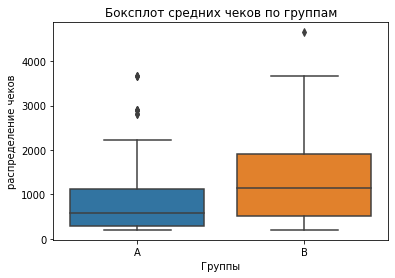

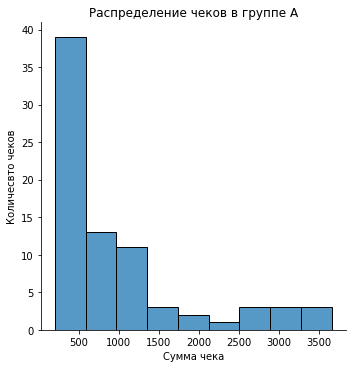

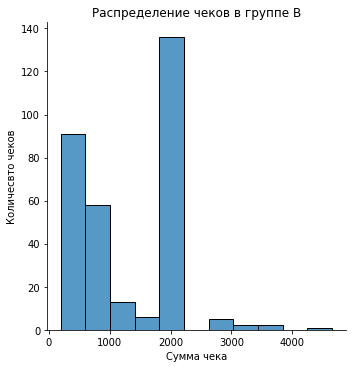

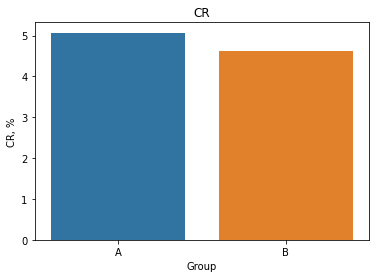

In [50]:
plots()